With the help of Metrica Sample data, I wanted to build a function to plot a Voronoi diagram.

In mathematics, a Voronoi diagram is a partition of a plane into regions close to each of a given set of objects.

This Voronoi diagram would give us an idea about the pitch control each team has at any given point of time.

I started off with importing the data to get a few frames I might plot the Voronoi diagram on.

In [4]:
# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
import math
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd
import os
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os
from os.path import basename

# Working with JSON
import json
from pandas.io.json import json_normalize

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno

# Progress Bar
from tqdm import tqdm

# Laurie Shaw's custom libraries for working with Metrica Sports data
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import Metrica_PitchControl as mpc
import Metrica_EPV as mepv

# Football libraries
from FCPython import createPitch

# Display in Jupyter
from IPython.display import Image, Video, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print('Setup Complete')

Setup Complete


In [5]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..', '..', '..')
data_dir = os.path.join(base_dir, 'data')
data_dir_metrica = os.path.join(base_dir, 'data', 'metrica')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
video_dir = os.path.join(base_dir, 'video')

In [6]:
# Define match to import (2 matches available)
game_id = 2     # sample match 2

# read in the event data
events = mio.read_event_data(data_dir_metrica, game_id)

In [7]:
df_tracking_home = mio.tracking_data(data_dir_metrica, game_id,'Home')
df_tracking_away = mio.tracking_data(data_dir_metrica, game_id,'Away')

Reading team: home
Reading team: away


In [8]:
#scaling the data to Metric coordinates with the lower corner of the pitch at 0,0
def metric_scale(data):
    x_columns = [c for c in data.columns if c[-1].lower()=='x']
    y_columns = [c for c in data.columns if c[-1].lower()=='y']
    data[x_columns] = (data[x_columns]) * 104
    data[y_columns] = (1-data[y_columns]) * 68
    return data

In [9]:
df_tracking_home = metric_scale(df_tracking_home)
df_tracking_away = metric_scale(df_tracking_away)

In [25]:
df_tracking_home

,Period,Time [s],Home_11_x,Home_11_y,Home_1_x,Home_1_y,Home_2_x,Home_2_y,Home_3_x,Home_3_y,...,Home_10_x,Home_10_y,Home_12_x,Home_12_y,Home_13_x,Home_13_y,Home_14_x,Home_14_y,ball_x,ball_y
Frame,,,,,,,,,,,,,,,,,,,,,
1,1,0.04,98.0460,33.71916,67.40448,48.54860,70.46208,38.89396,72.67728,30.18792,...,52.20176,26.43636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,0.08,98.0460,33.71916,67.40448,48.54860,70.46208,38.89396,72.67728,30.18792,...,52.20176,26.43636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.12,98.0460,33.71916,67.40448,48.54860,70.46208,38.89396,72.67728,30.18792,...,52.20176,26.43636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0.16,98.0460,33.71916,67.40448,48.54860,70.46208,38.89396,72.67728,30.18792,...,52.20176,26.43636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,0.20,98.0460,33.71916,67.40448,48.54860,70.46208,38.89396,72.67728,30.18792,...,52.20176,26.43636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141152,2,5646.08,6.5364,33.15476,40.03896,57.55792,23.46032,39.87860,28.22768,46.09788,...,NaN,NaN,42.47048,58.17468,53.07328,3.70328,29.08048,43.04400,NaN,NaN
141153,2,5646.12,6.5364,33.15476,40.03896,57.55792,23.46032,39.87860,28.22768,46.09788,...,NaN,NaN,42.47048,58.17468,53.07224,3.65432,29.12936,43.03176,NaN,NaN
141154,2,5646.16,6.5364,33.15476,40.03896,57.55792,23.46032,39.87860,28.22768,46.09788,...,NaN,NaN,42.47048,58.17468,53.07016,3.59652,29.15224,43.02632,NaN,NaN


Let's take a random frame

In [10]:
frame = 136

In [11]:
ball_x = df_tracking_home.iloc[frame]['ball_x']
ball_y = df_tracking_home.iloc[frame]['ball_y']

In [12]:
home_x = []
home_y = []
for i in df_tracking_home.iloc[frame].keys():
    if "_x" in i and "ball" not in i:
        home_x.append(df_tracking_home.iloc[frame][i])
    if "_y" in i and "ball" not in i:
        home_y.append(df_tracking_home.iloc[frame][i])

In [13]:
away_x = []
away_y = []
for i in df_tracking_away.iloc[frame].keys():
    if "_x" in i and "ball" not in i:
        away_x.append(df_tracking_away.iloc[frame][i])
    if "_y" in i and "ball" not in i:
        away_y.append(df_tracking_away.iloc[frame][i])

Below is a function to plot a pitch via Matplotlib

In [14]:
import matplotlib.pyplot as plt
from matplotlib import patches

def draw_pitch(pitch_color="#FFFFFF", line_color="#000000", area="full"):
    
    """Plots a Football Pitch with dimensions 104X68
    Parameters:
    
    pitch_color (str):The color of the pitch. Default value is white.
    line_color (str):The color of the lines on the pitch. Default value is black.
    area (str):A vairable to decide whether we want half a pitch or full. Default value is full.
    """
    
    if area=='full':
        
        fig = plt.figure(figsize=(10.4,6.8))
        ax = fig.add_subplot(1,1,1)
        ax.patch.set_facecolor(pitch_color)
        ax.axis('off')
        
        #Outer Pitchlines
        outer_x = [0,104,104,0,0]
        outer_y = [0,0,68,68,0]
        plt.plot(outer_x,outer_y,color=line_color,zorder=5)
        
        #Centre line
        plt.plot([52,52],[0,68],color=line_color,zorder=5)
        
        #Outer Boxes
        left_outer_x = [104,87.5,87.5,104]
        left_outer_y = [13.84,13.84,54.16,54.16] 
        plt.plot(left_outer_x,left_outer_y,color=line_color,zorder=5)
        
        right_outer_x = [0,16.5,16.5,0]
        right_outer_y = [13.84,13.84,54.16,54.16] 
        plt.plot(right_outer_x,right_outer_y,color=line_color,zorder=5)
        
        #Goals
        left_goal_y = [30.34,30.34,37.66,37.66]
        left_goal_x = [0,-0.2,-0.2,0]
        plt.plot(left_goal_x,left_goal_y,color=line_color,zorder=5)
        
        right_goal_x = [104,104.2,104.2,104]
        right_goal_y = [30.34,30.34,37.66,37.66]
        plt.plot(right_goal_x,right_goal_y,color=line_color,zorder=5)
        
        #6 Yard Boxes
        left_six_x = [0,4.5,4.5,0]
        left_six_y = [24.84,24.84,43.16,43.16]
        plt.plot(left_six_x,left_six_y,color=line_color,zorder=5)
        
        right_six_x = [104,99.5,99.5,104]
        right_six_y = [24.84,24.84,43.16,43.16]
        plt.plot(right_six_x,right_six_y,color=line_color,zorder=5)
        
        #Penalty and centre spot
        plt.scatter(93,34,color=line_color,zorder=5)
        plt.scatter(11,34,color=line_color,zorder=5)
        plt.scatter(52,34,color=line_color,zorder=5)
        
        centre_circle = plt.Circle((52, 34), 9.15,ls='solid',lw=1.5,color=line_color, fill=False, zorder=2,alpha=1)
        left_circle = plt.Circle((10.5,34), 9.15,ls='solid',lw=1.5,color=line_color, fill=False, zorder=1,alpha=1)
        right_circle = plt.Circle((93.5,34), 9.15,ls='solid',lw=1.5,color=line_color, fill=False, zorder=1,alpha=1)

        #To hide the circle's extra part to only leave the D.
        rec1 = plt.Rectangle((87.5,20), 16,30,ls='-',color=pitch_color, zorder=1,alpha=1)
        rec2 = plt.Rectangle((0, 20), 16.5,30,ls='-',color=pitch_color, zorder=1,alpha=1)
        
        ax.add_patch(centre_circle)
        ax.add_patch(left_circle)
        ax.add_patch(right_circle)
        
        ax.add_patch(rec1)
        ax.add_patch(rec2)
        return ax
        
    if area=="half":
        
        fig = plt.figure(figsize=(6.8,5.2))
        ax = fig.add_subplot(1,1,1)
        ax.patch.set_facecolor(pitch_color)
        ax.axis('off')
        
        #Outer Pitchlines
        outer_x = [0,0,68,68,0]
        outer_y = [0,52,52,0,0]
        plt.plot(outer_x,outer_y,color=line_color,zorder=5)
        
        #OuterBox
        box_x = [13.84,13.84,54.16,54.16]
        box_y = [52,35.5,35.5,52]
        plt.plot(box_x,box_y,color=line_color,zorder=5)
        
        #Goal
        goal_x = [30.34,30.34,37.66,37.66]
        goal_y = [52,52.2,52.2,52]
        plt.plot(goal_x,goal_y,color=line_color,zorder=5)
        
        #6 Yard Box
        six_x = [24.84,24.84,43.16,43.16]
        six_y = [52,47.5,47.5,52]
        plt.plot(six_x,six_y,color=line_color,zorder=5)
        
        #Centre Sport and Penalty Spot 
        plt.scatter(34,0,color=line_color,zorder=5)
        plt.scatter(34,41,color=line_color,zorder=5)
        
        #Centre circle and D
        centre_circle = plt.Circle((34, 0), 9.15,ls='solid',lw=1.5,color=line_color, fill=False, zorder=2,alpha=1)
        upper_circle = plt.Circle((34,41.5), 9.15,ls='solid',lw=1.5,color=line_color, fill=False, zorder=1,alpha=1)
        
        #Rectangle to hide the extra part of the D
        rec1 = plt.Rectangle((23, 35.5), 30,16.5,ls='-',color=_color, zorder=1,alpha=1)
        
        
        ax.add_patch(centre_circle)
        ax.add_patch(upper_circle)
        ax.add_patch(rec1)
        return ax


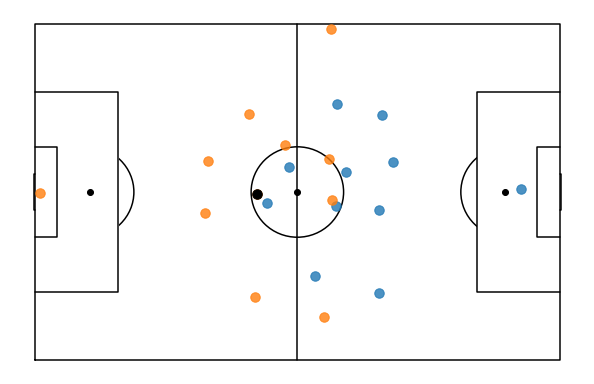

In [15]:
ax = draw_pitch()
ax.scatter(home_x,home_y,s=90.,zorder=12,alpha=0.8)
ax.scatter(away_x,away_y,s=90.,zorder=12,alpha=0.8)
ax.scatter(ball_x,ball_y,s=90.,zorder=12,color='black')

Turns out scipy library already has a Voronoi function.

In [16]:
x = home_x+away_x
y = home_y+away_y

In [17]:
x = [c for c in x if str(c)!='nan']
y = [c for c in y if str(c)!='nan']

In [18]:
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(tuple(zip(x,y)))

(-10, 100)

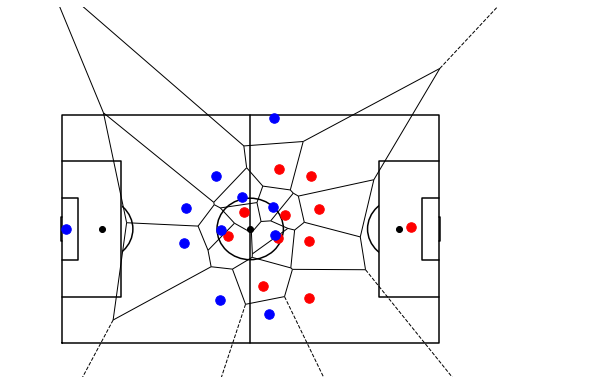

In [19]:
ax = draw_pitch()
voronoi_plot_2d(vor, ax, show_vertices=False, show_points=False)
ax.scatter(home_x, home_y, color='red', s=90,zorder=12)
ax.scatter(away_x,away_y, c='blue', s=90,zorder=12)
plt.xlim(-15,145)
plt.ylim(-10,100)

The problem with the above function is that it does not know about the boundaries of our pitch and so the polygons extend outside of our pitch.

To counter this, I came up with a rather neat hack.

Reflecting the points on all touchlines and generating a voronoi diagram with all these would ensure that all the vertices for the Voronoi diagram are inside the field.

Let's generate these reflected points

In [20]:
points = list(tuple(zip(x,y)))
points = points+[(i[0],-1*i[1]) for i in tuple(zip(x,y))]+[(-1*i[0],i[1]) for i in tuple(zip(x,y))]+[(104-i[0]+104,1*i[1]) for i in tuple(zip(x,y))]+[(i[0],68-i[1]+68) for i in tuple(zip(x,y))]

(-68, 141)

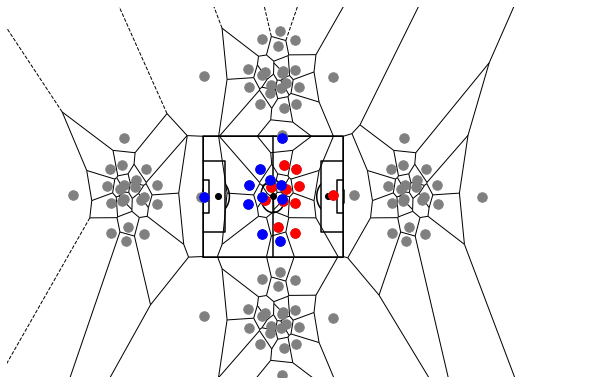

In [21]:
ax = draw_pitch()
vor = Voronoi(points)
voronoi_plot_2d(vor, ax, show_vertices=False, show_points=False)
ex_x,ex_y = zip(*points)
ax.scatter(ex_x,ex_y,c='grey',s=90,zorder=12)
ax.scatter(home_x, home_y, c='red', s=90,zorder=12)
ax.scatter(away_x,away_y, c='blue', s=90,zorder=12)
plt.xlim(-145,285)
plt.ylim(-68,141)

Granted the above looks quite ugly but out purpose is solved. The pitch contains closed polygons.

(0, 68)

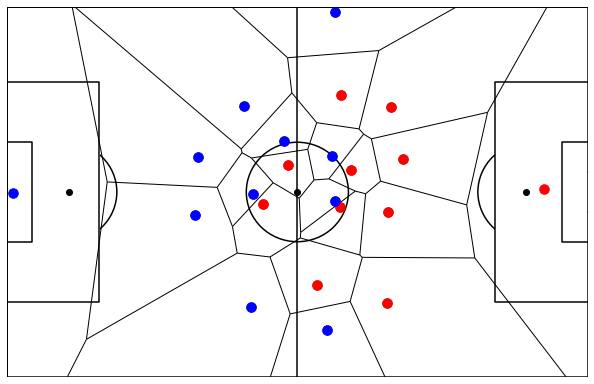

In [22]:
ax = draw_pitch()
vor = Voronoi(points)
voronoi_plot_2d(vor, ax, show_vertices=False, show_points=False)
ex_x,ex_y = zip(*points)
ax.scatter(ex_x,ex_y,c='grey',s=90)
ax.scatter(home_x, home_y, c='red', s=90,zorder=12)
ax.scatter(away_x,away_y, c='blue', s=90,zorder=12)
plt.xlim(0,104)
plt.ylim(0,68)

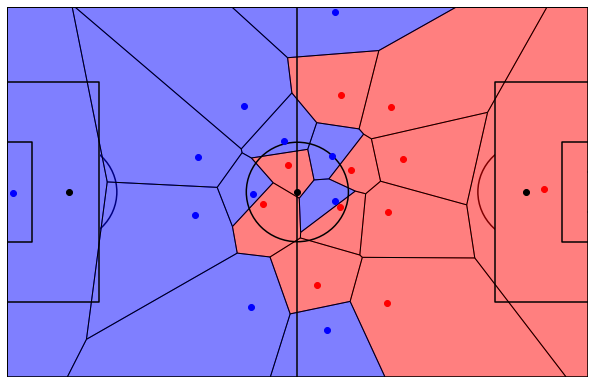

In [23]:
ax = draw_pitch()
x,y = zip(*vor.points)
voronoi_plot_2d(vor, ax, show_points=False, show_vertices=False, s=1)
for r in range(len(vor.point_region)):
    region = vor.regions[vor.point_region[r]]
    if not -1 in region:
        polygon = [vor.vertices[i] for i in region]
        if x[r] in home_x and y[r] in home_y:
            plt.scatter(x[r],y[r],color='red',zorder=12)
            plt.fill(*zip(*polygon),color='red',alpha=0.5)
        if x[r] in away_x and y[r] in away_y:
            plt.scatter(x[r],y[r],color='blue',zorder=12)
            plt.fill(*zip(*polygon),color='blue',alpha=0.5)
            
plt.xlim(0,104)
plt.ylim(0,68)
plt.show()


And there we have it. We can generate Voronoi diagram for any given frame just by changing the frame number above and re-running all the cells.